# PRIMAVERA models: SST bias & gradients 

In [1]:
import numpy as np
from numpy import *
import bisect
import scipy as sp
from scipy.stats import gaussian_kde, ttest_ind
import numpy.matlib 
import math
from scipy import signal
from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from datetime import *
import datetime as datet
from dateutil.relativedelta import relativedelta, MO
import calendar
import matplotlib.animation as animation
from matplotlib import rc
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
import os
import glob
from tqdm import tqdm

In [2]:
# Set up cluster
cluster = LocalCluster(n_workers=4, threads_per_worker=4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33831,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:35107,Total threads: 4
Dashboard: http://127.0.0.1:38361/status,Memory: 58.84 GiB
Nanny: tcp://127.0.0.1:36579,


In [3]:
model_name =['ERA5_','HadGEM3-GC31_','CNRM-CM6_','EC-Earth3P_','ECMWF-IFS_','CMCC-CM2_', 'MPI-ESM1-2_','FOCI_']
ERA5_variable = ['sea_surface_temperature','surface_latent_heat_flux']
ERA5_var_name = ['var34', 'var147']
FOCI_variable = ['tsw','ahfl']
variable = ['tos_','hfls_']
resolution = [[''],
              ['-LL', '-MM', '-HH'],
              ['-1' , '-1-HR'],
              ['', '-HR'],
              ['-LR', '-MR','-HR'],
              ['-HR4','-VHR4'],
              ['-HR', '-XR','-HR-PP', '-ER'],
              ['-Standard' ,'-VIKING10']]

## Load SST + SLHF data and calculate + print JJA biases

In [4]:
HighRes_model_JJA_bias = {}
HighRes_model={}
HighRes_model_JJA_bias_sep = {}
HighRes_model_p_value = {}
for mod in range(len(model_name)):
    for var in range(len(variable)):
        for res in range(len(resolution[mod])):
            
            ### Load data sets ###
            
            if mod==0:
                #Input of ERA5  
                directory='/work/bm1398/m301111/Reanalysis/ERA5/daily/ERA5__'; file_end= '__1979-2019.nc'
                HighRes_model['ERA5_'+variable[var]]=xr.open_dataset(directory+ERA5_variable[var]+'__1979-2019.nc')                  
            elif mod>0 and mod<7:
                #Input of HighResMIP models
                directory ='/work/bm1398/m301111/Models/HighResMIP/'+model_name[mod][:-1]+'/'+variable[var][:-1]+'/'+variable[var]+'daily/'+variable[var]+'day_'+model_name[mod][:-1]; #file_end='_control-1950_r1i1p1f1_gn_19500101-20501231_2_5_deg_06_00_shifted_inverted.nc'
                file=glob.glob(directory+resolution[mod][res]+'_control*.nc')
                HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]] = xr.open_dataset(file[0]) 
                # Correct time coordinate in MPI_ESM ER and PP runs in SLHF with the time coordinate from SST versions
                if (model_name[mod] =='MPI-ESM1-2_' and variable[var]=='hfls_' and resolution[mod][res] == '-HR-PP' or resolution[mod][res] == '-ER'):
                    HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]]['time']= HighRes_model[model_name[mod]+'tos_'+resolution[mod][res]]['time']      
            elif mod==7:
                #Input of FOCI
                period ='1950-2049'
                path =     '/work/bm1398/m301111/Models/FOCI/FOCI1.10-TM020_preind_no_nest/'+period+'/'
                path_nest= '/work/bm1398/m301111/Models/FOCI/FOCI1.10-TM026_preind_VIKING10_nest/'+period+'/'
                if res==0:
                    FOCI_file       = path+'FOCI1.10-TM020_echam6_echam_'+period+'_'+FOCI_variable[var]+'.nc'
                if res==1:
                    FOCI_file   = path_nest+'FOCI1.10-TM026_echam6_echam_'+period+'_'+FOCI_variable[var]+'.nc'
                HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]] = xr.open_dataset(FOCI_file)  
                if variable[var]=='tos_':
                    # FOCI SST values overlaid by ERA5 land sea mask
                    HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]] = xr.where(HighRes_model['ERA5_'+variable[var]][ERA5_var_name[var]].sel(time=slice('1979-01-01T06:00:00','1979-01-01T06:00:00')).squeeze().isnull(),HighRes_model['ERA5_'+variable[var]][ERA5_var_name[var]].sel(time=slice('1979-01-01T06:00:00','1979-01-01T06:00:00')).squeeze(),HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]][FOCI_variable[var]])
            
            ### Calculate JJA bias for each model configuration and both variables (SST + SLHF) ###
            
            weights = np.cos(np.deg2rad(HighRes_model[model_name[mod]+variable[0]+resolution[mod][0]].lat)) 
            if mod>0 and mod<7:
                HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias'] = HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]][variable[var][:-1]].groupby('time.season').mean('time').sel(season='JJA') - HighRes_model['ERA5_'+variable[var]][ERA5_var_name[var]].groupby('time.season').mean('time').sel(season='JJA')
                
                # Compute JJA means for each year separately
                HighRes_model_JJA_bias_sep [model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias_sep'] = HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]][variable[var][:-1]].sel(time=HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]][variable[var][:-1]].time.dt.month.isin([6, 7, 8])).assign_coords(year=HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]][variable[var][:-1]].time.dt.year).groupby('year').mean() - HighRes_model['ERA5_'+variable[var]][ERA5_var_name[var]].groupby('time.season').mean('time').sel(season='JJA')  
                
                # Test whether JJA bias sample is different from zero
                _, HighRes_model_p_value [model_name[mod]+variable[var]+resolution[mod][res]+'p_value'] = stats.ttest_1samp(HighRes_model_JJA_bias_sep [model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias_sep'], 0, axis=0)
                    
                if variable[var]=='tos_':
                    if mod==6 and res==2 or res==3:
                        print(model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias', "{:.1f}".format(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias'].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).weighted(weights) .mean('lon', skipna=True).mean('lat', skipna=True)[0].values))
                    else:
                        print(model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias', "{:.1f}".format(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias'].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).weighted(weights) .mean('lon', skipna=True).mean('lat', skipna=True).values))
                   
                if variable[var]=='hfls_':
                    print(model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias', "{:.1f}".format(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias'].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).weighted(weights) .mean('lon', skipna=True).mean('lat', skipna=True).values))

            # for FOCI with ERA5 mask already applied 
            elif mod==7: 
                if variable[var]=='tos_':
                    HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias'] = HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]].groupby('time.season').mean('time').sel(season='JJA') - HighRes_model['ERA5_'+variable[var]][ERA5_var_name[var]].groupby('time.season').mean('time').sel(season='JJA')
                    print(model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias', "{:.1f}".format(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias'].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).weighted(weights) .mean('lon', skipna=True).mean('lat', skipna=True).values))
                    
                    # Compute JJA means for each year separately
                    HighRes_model_JJA_bias_sep [model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias_sep'] = HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]].sel(time=HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]].time.dt.month.isin([6, 7, 8])).assign_coords(year=HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]].time.dt.year).groupby('year').mean() - HighRes_model['ERA5_'+variable[var]][ERA5_var_name[var]].groupby('time.season').mean('time').sel(season='JJA')  
            
                    # Test whether JJA bias sample is different from zero
                    _, HighRes_model_p_value [model_name[mod]+variable[var]+resolution[mod][res]+'p_value'] = stats.ttest_1samp(HighRes_model_JJA_bias_sep [model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias_sep'], 0, axis=2)
 
                if variable[var]=='hfls_':
                    HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias'] = HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]][FOCI_variable[var]].groupby('time.season').mean('time').sel(season='JJA') - HighRes_model['ERA5_'+variable[var]][ERA5_var_name[var]].groupby('time.season').mean('time').sel(season='JJA')
                    print(model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias', "{:.1f}".format(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias'].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).weighted(weights) .mean('lon', skipna=True).mean('lat', skipna=True).values,'\n'))
                    
                    # Compute JJA means for each year separately
                    HighRes_model_JJA_bias_sep [model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias_sep'] = HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]][FOCI_variable[var]].sel(time=HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]][FOCI_variable[var]].time.dt.month.isin([6, 7, 8])).assign_coords(year=HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]][FOCI_variable[var]].time.dt.year).groupby('year').mean() - HighRes_model['ERA5_'+variable[var]][ERA5_var_name[var]].groupby('time.season').mean('time').sel(season='JJA')  
            
                    # Test whether JJA bias sample is different from zero
                    _, HighRes_model_p_value [model_name[mod]+variable[var]+resolution[mod][res]+'p_value'] = stats.ttest_1samp(HighRes_model_JJA_bias_sep [model_name[mod]+variable[var]+resolution[mod][res]+'_JJA_bias_sep'], 0, axis=0)

%store HighRes_model 
%store HighRes_model_JJA_bias
%store HighRes_model_JJA_bias_sep
%store HighRes_model_p_value    

HadGEM3-GC31_tos_-LL_JJA_bias -3.1
HadGEM3-GC31_tos_-MM_JJA_bias -0.6
HadGEM3-GC31_tos_-HH_JJA_bias 0.2
HadGEM3-GC31_hfls_-LL_JJA_bias -11.9
HadGEM3-GC31_hfls_-MM_JJA_bias 2.6
HadGEM3-GC31_hfls_-HH_JJA_bias 7.1
CNRM-CM6_tos_-1_JJA_bias -1.1
CNRM-CM6_tos_-1-HR_JJA_bias -0.4
CNRM-CM6_hfls_-1_JJA_bias -6.7
CNRM-CM6_hfls_-1-HR_JJA_bias 0.0
EC-Earth3P_tos__JJA_bias -1.7
EC-Earth3P_tos_-HR_JJA_bias -1.1
EC-Earth3P_hfls__JJA_bias -12.6
EC-Earth3P_hfls_-HR_JJA_bias -8.0
ECMWF-IFS_tos_-LR_JJA_bias -7.0
ECMWF-IFS_tos_-MR_JJA_bias -1.2
ECMWF-IFS_tos_-HR_JJA_bias -1.6
ECMWF-IFS_hfls_-LR_JJA_bias -22.8
ECMWF-IFS_hfls_-MR_JJA_bias -3.2
ECMWF-IFS_hfls_-HR_JJA_bias -2.9
CMCC-CM2_tos_-HR4_JJA_bias 1.2
CMCC-CM2_tos_-VHR4_JJA_bias 1.0
CMCC-CM2_hfls_-HR4_JJA_bias 3.7
CMCC-CM2_hfls_-VHR4_JJA_bias 5.2
MPI-ESM1-2_tos_-HR_JJA_bias -0.7
MPI-ESM1-2_tos_-XR_JJA_bias -1.4
MPI-ESM1-2_tos_-HR-PP_JJA_bias -2.9
MPI-ESM1-2_tos_-ER_JJA_bias -2.1
MPI-ESM1-2_hfls_-HR_JJA_bias -13.6
MPI-ESM1-2_hfls_-XR_JJA_bias -16.3
MPI-

## Restore stored variables 

In [5]:
#%store -r HighRes_model 
#%store -r HighRes_model_JJA_bias
#%store -r HighRes_model_JJA_bias_sep
#%store -r HighRes_model_p_value 

## Calculate differences between absolute values of biases (differences between individual resolution and ERA5) together with One Sample T-Test

In [6]:
HighRes_model_JJA_bias_diff={}
HighRes_model_JJA_bias_sep_diff = {}
HighRes_model_p_value_diff= {}
for mod in range(1,len(model_name)):
    for var in range(len(variable)):
        if mod==6:    # Calc JJA bias difference between MPI-ESM-PP-HR and MPI-ESM-PP-XR
            HighRes_model_JJA_bias_diff [model_name[mod]+variable[var]+resolution[mod][3]+resolution[mod][2]+'_JJA_bias_diff'] = abs(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][3]+'_JJA_bias']) - abs(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][2]+'_JJA_bias'])
            HighRes_model_JJA_bias_sep_diff [model_name[mod]+variable[var]+resolution[mod][3]+resolution[mod][2]+'_JJA_bias_sep_diff'] = abs(HighRes_model_JJA_bias_sep[model_name[mod]+variable[var]+resolution[mod][3]+'_JJA_bias_sep']) - abs(HighRes_model_JJA_bias_sep[model_name[mod]+variable[var]+resolution[mod][2]+'_JJA_bias_sep'])
            _, HighRes_model_p_value_diff [model_name[mod]+variable[var]+resolution[mod][3]+resolution[mod][2]+'p_value_diff'] = stats.ttest_1samp(HighRes_model_JJA_bias_sep_diff [model_name[mod]+variable[var]+resolution[mod][3]+resolution[mod][2]+'_JJA_bias_sep_diff'], 0, axis=0)

        else:           # Calc JJA bias difference between first and second model versions
            HighRes_model_JJA_bias_diff [model_name[mod]+variable[var]+resolution[mod][1]+resolution[mod][0]+'_JJA_bias_diff'] = abs(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][1]+'_JJA_bias']) - abs(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][0]+'_JJA_bias'])
            HighRes_model_JJA_bias_sep_diff [model_name[mod]+variable[var]+resolution[mod][1]+resolution[mod][0]+'_JJA_bias_sep_diff'] = abs(HighRes_model_JJA_bias_sep[model_name[mod]+variable[var]+resolution[mod][1]+'_JJA_bias_sep']) - abs(HighRes_model_JJA_bias_sep[model_name[mod]+variable[var]+resolution[mod][0]+'_JJA_bias_sep'])
            if mod==7 and var==0: ### FOCI has a different dim order, so calc p-value over axis=2
                _, HighRes_model_p_value_diff [model_name[mod]+variable[var]+resolution[mod][1]+resolution[mod][0]+'p_value_diff'] = stats.ttest_1samp(HighRes_model_JJA_bias_sep_diff [model_name[mod]+variable[var]+resolution[mod][1]+resolution[mod][0]+'_JJA_bias_sep_diff'], 0, axis=2)
            else: ### Otherwise calc p-value over axis=0
                _, HighRes_model_p_value_diff [model_name[mod]+variable[var]+resolution[mod][1]+resolution[mod][0]+'p_value_diff'] = stats.ttest_1samp(HighRes_model_JJA_bias_sep_diff [model_name[mod]+variable[var]+resolution[mod][1]+resolution[mod][0]+'_JJA_bias_sep_diff'], 0, axis=0)

            if mod==1:       # Calc JJA bias difference between HadGEM HH and HadGEM MM
                HighRes_model_JJA_bias_diff [model_name[mod]+variable[var]+resolution[mod][2]+resolution[mod][1]+'_JJA_bias_diff'] = abs(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][2]+'_JJA_bias']) - abs(HighRes_model_JJA_bias[model_name[mod]+variable[var]+resolution[mod][1]+'_JJA_bias'])
                HighRes_model_JJA_bias_sep_diff [model_name[mod]+variable[var]+resolution[mod][2]+resolution[mod][1]+'_JJA_bias_sep_diff'] = abs(HighRes_model_JJA_bias_sep[model_name[mod]+variable[var]+resolution[mod][2]+'_JJA_bias_sep']) - abs(HighRes_model_JJA_bias_sep[model_name[mod]+variable[var]+resolution[mod][1]+'_JJA_bias_sep'])
                _, HighRes_model_p_value_diff [model_name[mod]+variable[var]+resolution[mod][2]+resolution[mod][1]+'p_value_diff'] = stats.ttest_1samp(HighRes_model_JJA_bias_sep_diff [model_name[mod]+variable[var]+resolution[mod][2]+resolution[mod][1]+'_JJA_bias_sep_diff'], 0, axis=0)



## Change color maps and define SST box

In [7]:
white = np.array([1., 1., 1., 1.])
coolwarm = plt.cm.get_cmap('coolwarm', 256)
coolwarm_white = coolwarm(np.linspace(0, 1, 256))
coolwarm_white[120:136, :] = white
coolwarm_white_cm= ListedColormap(coolwarm_white)

seismic = plt.cm.get_cmap('seismic', 256)
seismic_white = seismic(np.linspace(0, 1, 256))
seismic_white[112:144, :] = white
seismic_white_cm= ListedColormap(seismic_white)

bwr = plt.cm.get_cmap('bwr', 256)
bwr_white = bwr(np.linspace(0, 1, 256))
bwr_white[112:144, :] = white
bwr_white_cm= ListedColormap(bwr_white)

PuOr_cmap = plt.cm.get_cmap('PuOr').reversed()

############

x1, y1 = [-40, -15], [45, 45]
x2, y2 = [-40, -15], [60, 60]
x3, y3 = [-40, -40], [45, 60]
x4, y4 = [-15, -15], [45, 60]

## Plot biases of Low-Res configurations: SST + SLHF

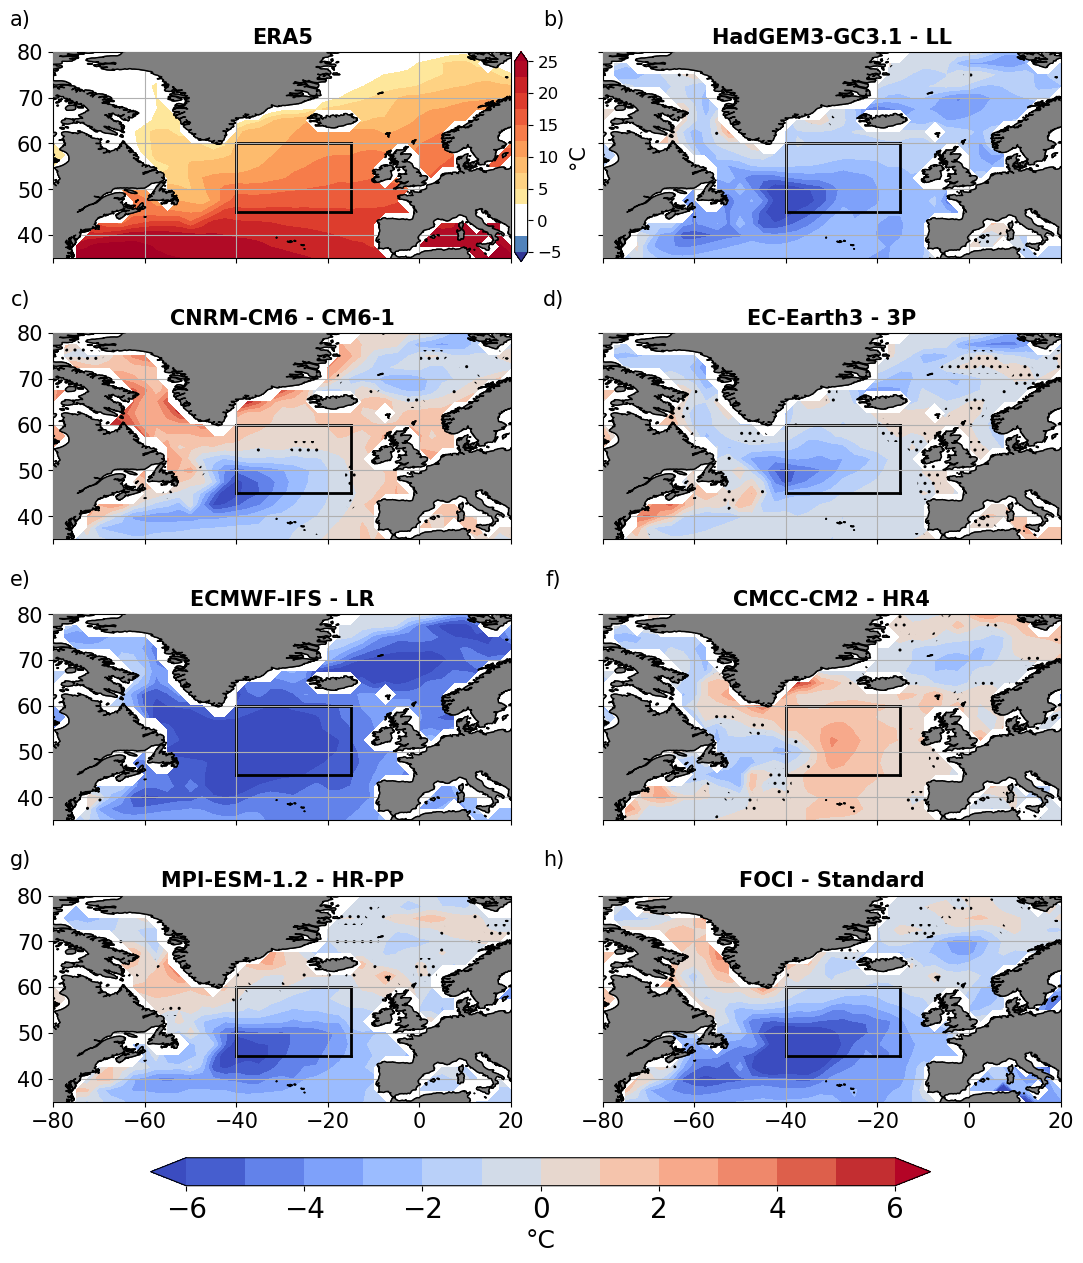

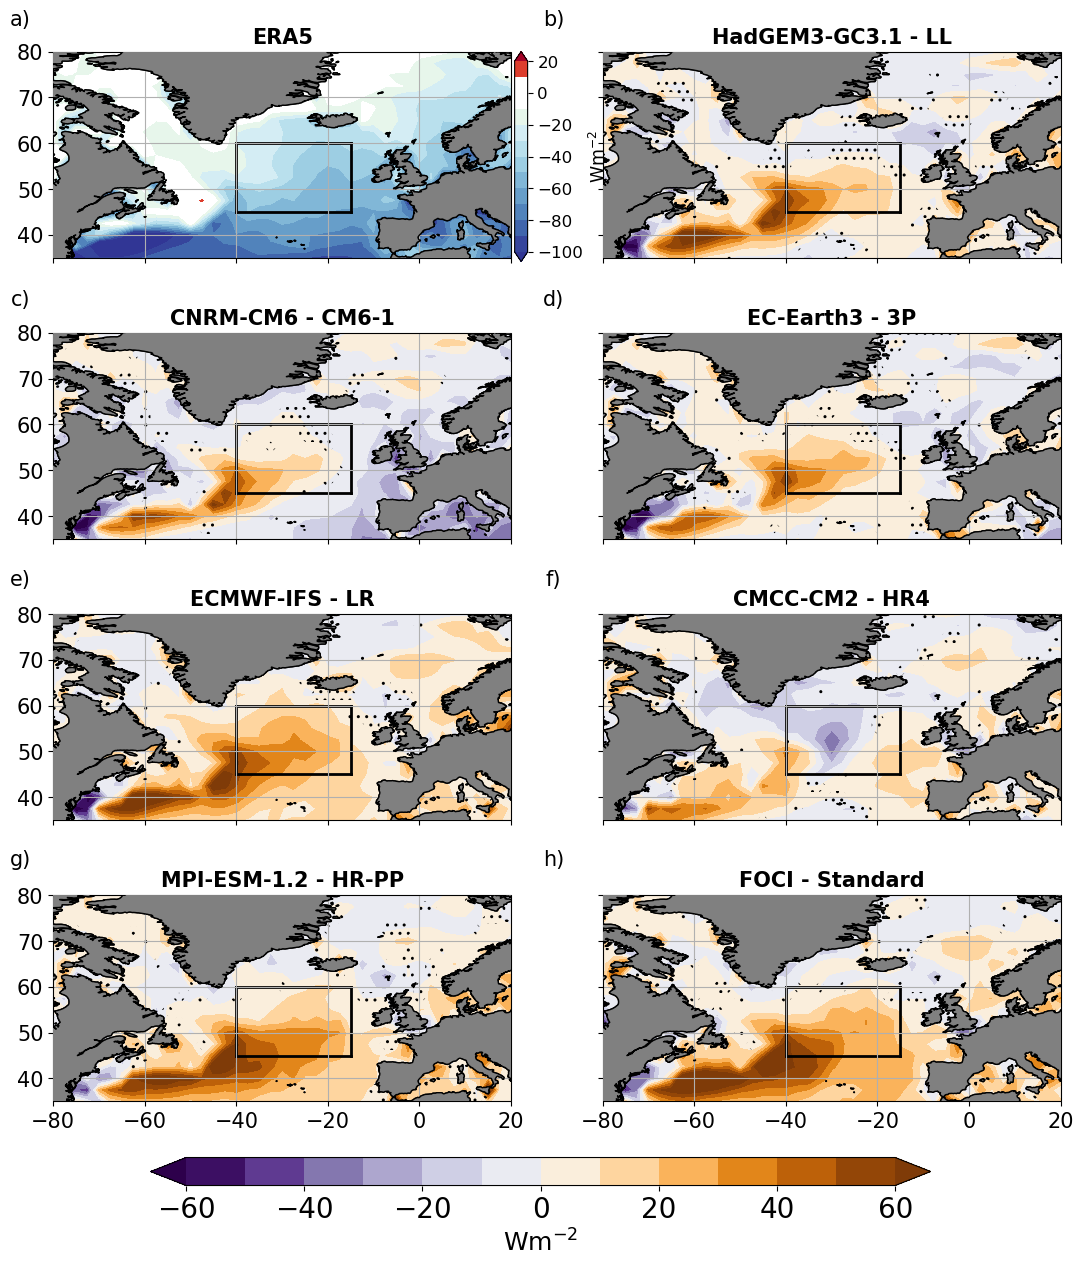

In [10]:
plt.rcParams['font.size'] = '15'
lon=np.linspace(0,360,145)
X, Y = np.meshgrid(lon,  HighRes_model['ERA5_tos_'].lat)
prj = ccrs.PlateCarree()
#offset=273.15
ERA5_SST_JJA_mean =  HighRes_model['ERA5_'+variable[0]][ERA5_var_name[0]].groupby('time.season').mean('time').sel(season='JJA')
ERA5_SLHF_JJA_mean =  HighRes_model['ERA5_'+variable[1]][ERA5_var_name[1]].groupby('time.season').mean('time').sel(season='JJA')
levels = np.linspace(-6, 6, 13)
titles = ['ERA5','HadGEM3-GC3.1 - LL','CNRM-CM6 - CM6-1','EC-Earth3 - 3P','ECMWF-IFS - LR','CMCC-CM2 - HR4', 'MPI-ESM-1.2 - HR-PP', 'FOCI - Standard']

for j in range(0,2):
    fig = plt.figure(figsize=(13,14), rasterized=True)
    axs=[]
    for i in range(1,9):
        axs.append(fig.add_subplot(4,2,i, projection=prj))
    for i in range(len(model_name)):
        
        if j==0: ### SST ###
            # Modify colormap
            RdYlBu = plt.cm.get_cmap('RdYlBu_r', 256)
            RdYlBu_white = RdYlBu(np.linspace(0, 1, 256))
            RdYlBu_white[90:144, :] = white
            RdYlBu_white_cm= ListedColormap(RdYlBu_white)
            if i==0: # ERA5
                norm = mcolors.TwoSlopeNorm(vcenter=0)
                contf= axs[i].contourf(X,Y,np.c_[ERA5_SST_JJA_mean, ERA5_SST_JJA_mean[:,0]], levels=np.linspace(-5,25,13), cmap=RdYlBu_white_cm,transform=prj,norm=norm, extend='both')
                axs[i].set_title(titles[i], size=15, fontweight='bold')
            elif i==7: # FOCI
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias[model_name[i]+variable[0]+resolution[i][0]+'_JJA_bias'], HighRes_model_JJA_bias[model_name[i]+variable[0]+resolution[i][0]+'_JJA_bias'][:,0]], levels= levels, cmap=coolwarm_white_cm,transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value [model_name[i]+variable[0]+resolution[i][0]+'p_value'], HighRes_model_p_value [model_name[i]+variable[0]+resolution[i][0]+'p_value'][:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
                axs[i].set_title(titles[i], size=15, fontweight='bold')
                
            elif i==6: # MPI-ESM PP low Res 
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias[model_name[i]+variable[0]+resolution[i][2]+'_JJA_bias'].squeeze(), HighRes_model_JJA_bias[model_name[i]+variable[0]+resolution[i][2]+'_JJA_bias'].squeeze()[:,0]], levels= levels, cmap=coolwarm_white_cm,transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value [model_name[i]+variable[0]+resolution[i][2]+'p_value'].squeeze(), HighRes_model_p_value [model_name[i]+variable[0]+resolution[i][2]+'p_value'].squeeze()[:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
                axs[i].set_title(titles[i], size=15, fontweight='bold')
            else:
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias[model_name[i]+variable[0]+resolution[i][0]+'_JJA_bias'], HighRes_model_JJA_bias[model_name[i]+variable[0]+resolution[i][0]+'_JJA_bias'][:,0]], levels= levels, cmap=coolwarm_white_cm,transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value [model_name[i]+variable[0]+resolution[i][0]+'p_value'], HighRes_model_p_value [model_name[i]+variable[0]+resolution[i][0]+'p_value'][:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
                axs[i].set_title(titles[i], size=15, fontweight='bold')
                

        elif j==1: ### SLHF ###
            # Modify colormap
            RdYlBu = plt.cm.get_cmap('RdYlBu_r', 256)
            RdYlBu_white = RdYlBu(np.linspace(0, 1, 256))
            RdYlBu_white[112:166, :] = white
            RdYlBu_white_cm= ListedColormap(RdYlBu_white)
            if i==0: # ERA5
                norm = mcolors.TwoSlopeNorm(vcenter=0)
                contf= axs[i].contourf(X,Y,np.c_[ERA5_SLHF_JJA_mean, ERA5_SLHF_JJA_mean[:,0]]*(-1), levels=np.linspace(-100,20,13), cmap=RdYlBu_white_cm,transform=prj, norm=norm, extend='both')
                axs[i].set_title(titles[i], size=15, fontweight='bold')
            elif i==7: # FOCI
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias[model_name[i]+variable[1]+resolution[i][0]+'_JJA_bias'], HighRes_model_JJA_bias[model_name[i]+variable[1]+resolution[i][0]+'_JJA_bias'][:,0]]*(-1), levels= np.linspace(-60,60,13), cmap=PuOr_cmap,transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value [model_name[i]+variable[1]+resolution[i][0]+'p_value'], HighRes_model_p_value [model_name[i]+variable[1]+resolution[i][0]+'p_value'][:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
                axs[i].set_title(titles[i], size=15, fontweight='bold')
            elif i==6: # MPI-ESM PP low Res 
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias[model_name[i]+variable[1]+resolution[i][2]+'_JJA_bias'].squeeze(), HighRes_model_JJA_bias[model_name[i]+variable[1]+resolution[i][2]+'_JJA_bias'].squeeze()[:,0]]*(-1), levels= np.linspace(-60,60,13), cmap=PuOr_cmap,transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value [model_name[i]+variable[1]+resolution[i][2]+'p_value'].squeeze(), HighRes_model_p_value [model_name[i]+variable[1]+resolution[i][2]+'p_value'].squeeze()[:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
                axs[i].set_title(titles[i], size=15, fontweight='bold')
            else:
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias[model_name[i]+variable[1]+resolution[i][0]+'_JJA_bias'], HighRes_model_JJA_bias[model_name[i]+variable[1]+resolution[i][0]+'_JJA_bias'][:,0]]*(-1), levels= np.linspace(-60,60,13), cmap=PuOr_cmap,transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value [model_name[i]+variable[1]+resolution[i][0]+'p_value'], HighRes_model_p_value [model_name[i]+variable[1]+resolution[i][0]+'p_value'][:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
                
                axs[i].set_title(titles[i], size=15, fontweight='bold')

    for ax in axs:
        ax.plot(x1, y1, x2, y2,x3,y3,x4,y4, color='black', linestyle='-', linewidth=2)
        ax.coastlines('50m')
        ax.add_feature(cart.feature.LAND, zorder=100, facecolor='grey', edgecolor='k')
        ax.gridlines()
        ax.set_extent([-80, 20, 35, 80], prj)
        ax.set_xticks([-80, -60, -40, -20,0,20],crs=prj)
        ax.set_yticks([40, 50, 60, 70,80],crs=prj)
    
    [axs[s].set_xticklabels([]) for s in range(6)]
    [axs[s].set_yticklabels([]) for s in [1,3,5,7]]
    
    plt.figtext(0.1,0.9,"a)", ha="center", va="top")
    plt.figtext(0.51,0.9,"b)", ha="center", va="top")
    plt.figtext(0.1,0.7,"c)", ha="center", va="top")
    plt.figtext(0.51,0.7,"d)", ha="center", va="top")
    plt.figtext(0.1,0.5,"e)", ha="center", va="top")
    plt.figtext(0.51,0.5,"f)", ha="center", va="top")
    plt.figtext(0.1,0.3,"g)", ha="center", va="top")
    plt.figtext(0.51,0.3,"h)", ha="center", va="top")

    if j==0:
        cb_ax = fig.add_axes([0.48, 0.72, 0.01, 0.15])
        cb = fig.colorbar(contf, cax=cb_ax, orientation='vertical')
        cb.ax.tick_params(labelsize=12)
        cb.set_label(label='°C')
        
        cb_ax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
        cb = fig.colorbar(cont, cax=cb_ax, orientation='horizontal')
        cb.ax.tick_params(labelsize=20)
        cb.set_label(label='°C', size='large')
        
    elif j==1:
        cb_ax = fig.add_axes([0.48, 0.72, 0.01, 0.15])
        cb = fig.colorbar(contf, cax=cb_ax, orientation='vertical')
        cb.ax.tick_params(labelsize=12)
        cb.set_label(label='Wm$^{-2}$', size='small')
    
        cb_ax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
        cb = fig.colorbar(cont, cax=cb_ax, orientation='horizontal')
        cb.ax.tick_params(labelsize=20)
        cb.set_label(label='Wm$^{-2}$', size='large')
        
    plt.savefig('figs/HighResMIP_JJA_bias_'+variable[j]+'.pdf', bbox_inches='tight', dpi=200)

## Plot differences of absolute biases between high and low resolution versions

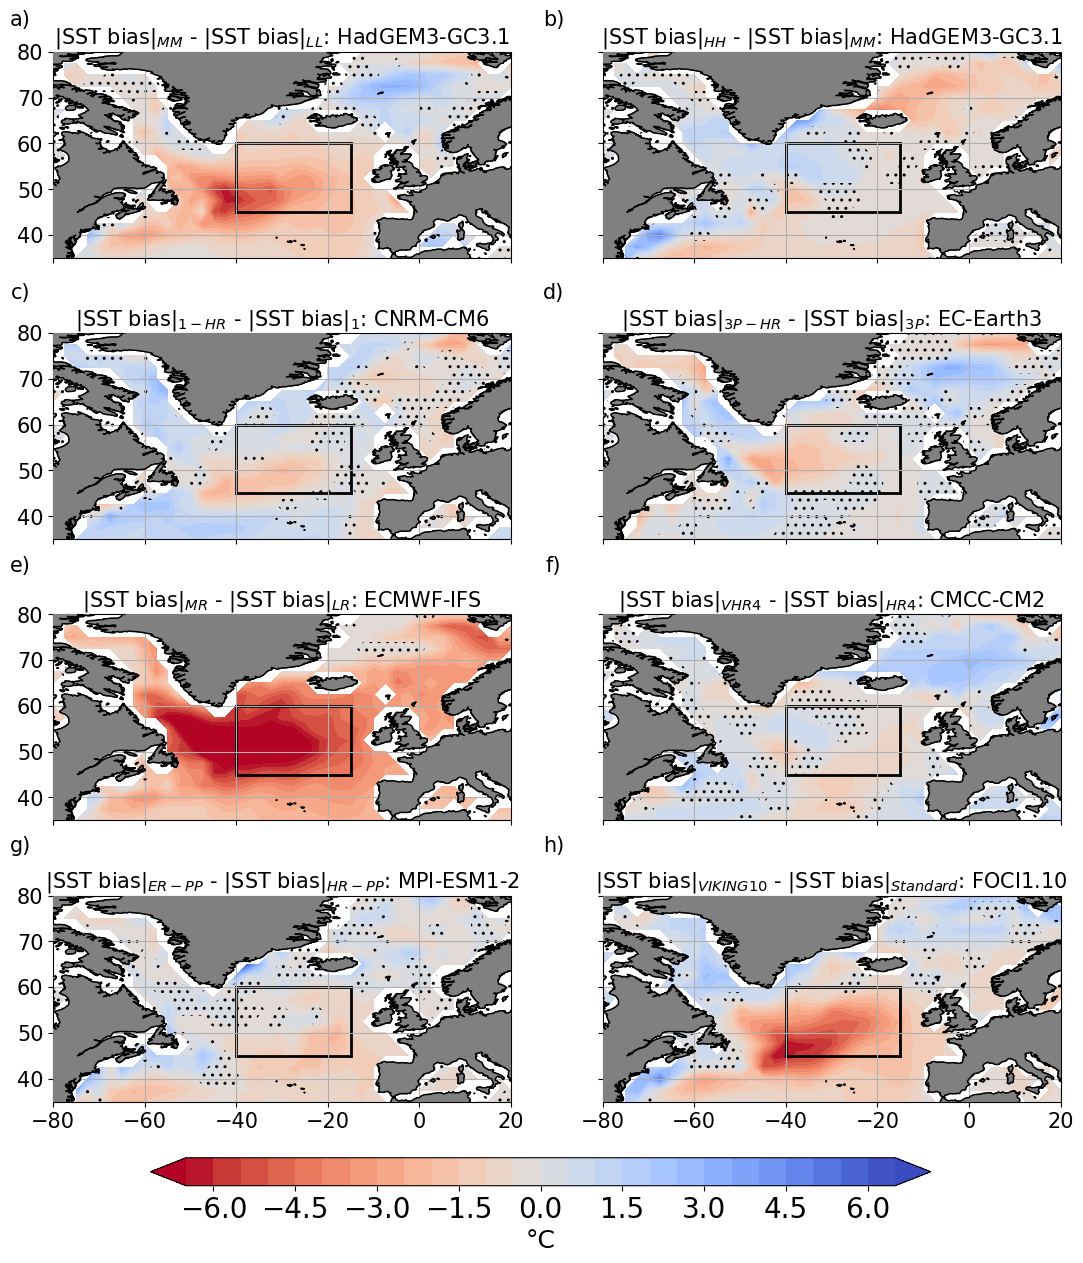

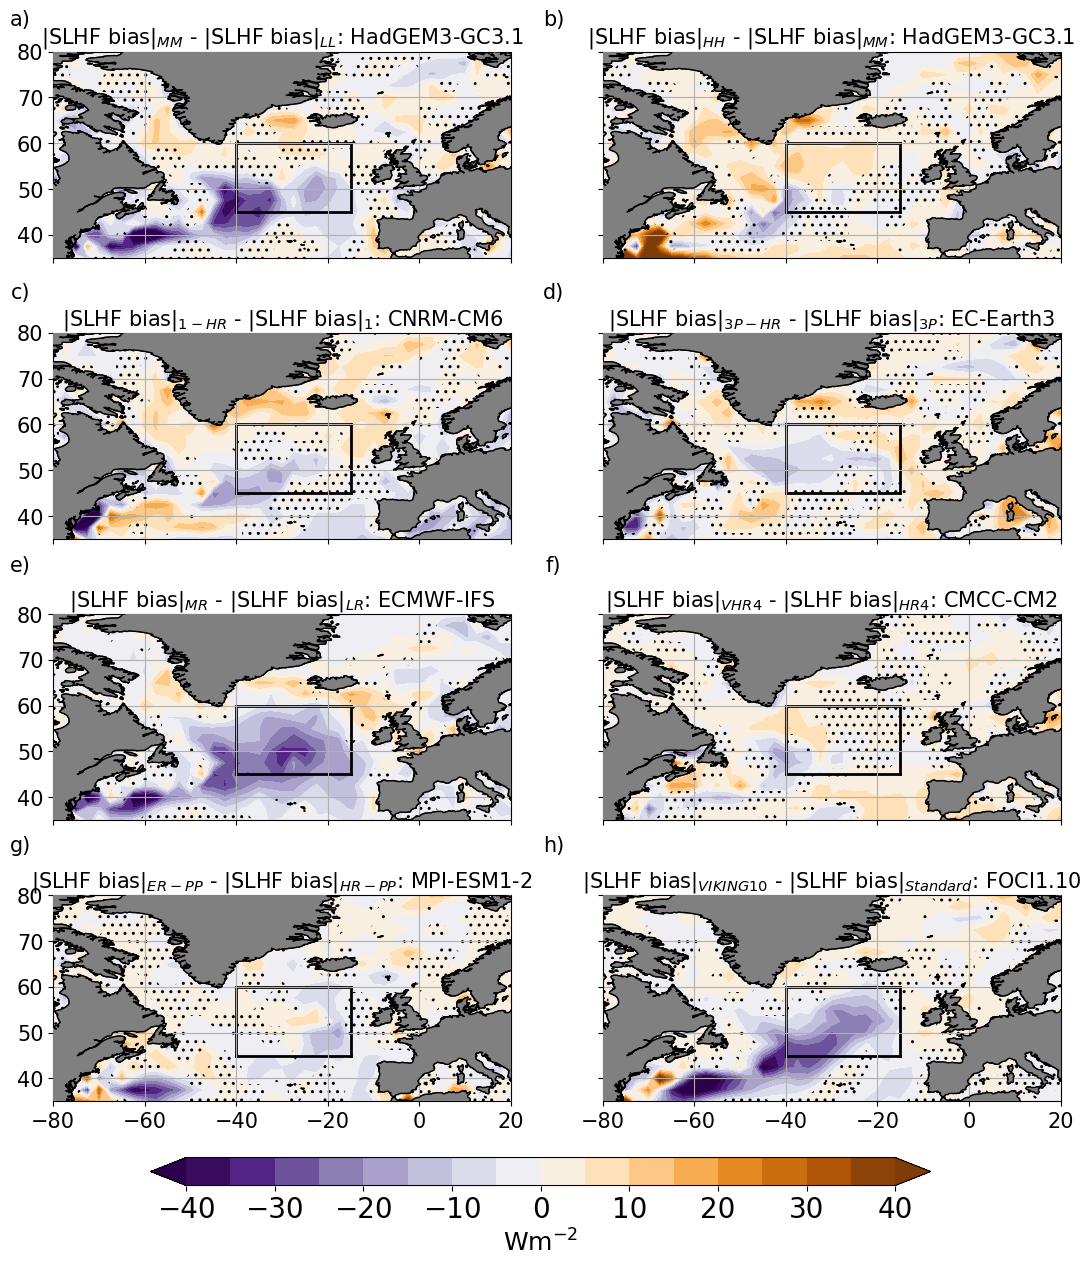

In [11]:
levels = np.linspace(-6.5, 6.5, 27)
titles_SST = ['|SST bias|$_{MM}$ - |SST bias|$_{LL}$: HadGEM3-GC3.1', 
          '|SST bias|$_{HH}$ - |SST bias|$_{MM}$: HadGEM3-GC3.1',
          '|SST bias|$_{1-HR}$ - |SST bias|$_{1}$: CNRM-CM6', 
          '|SST bias|$_{3P-HR}$ - |SST bias|$_{3P}$: EC-Earth3', 
          '|SST bias|$_{MR}$ - |SST bias|$_{LR}$: ECMWF-IFS',
          '|SST bias|$_{VHR4}$ - |SST bias|$_{HR4}$: CMCC-CM2',
          '|SST bias|$_{ER-PP}$ - |SST bias|$_{HR-PP}$: MPI-ESM1-2', 
          '|SST bias|$_{VIKING10}$ - |SST bias|$_{Standard}$: FOCI1.10']

titles_SLHF = ['|SLHF bias|$_{MM}$ - |SLHF bias|$_{LL}$: HadGEM3-GC3.1', 
          '|SLHF bias|$_{HH}$ - |SLHF bias|$_{MM}$: HadGEM3-GC3.1',
          '|SLHF bias|$_{1-HR}$ - |SLHF bias|$_{1}$: CNRM-CM6', 
          '|SLHF bias|$_{3P-HR}$ - |SLHF bias|$_{3P}$: EC-Earth3', 
          '|SLHF bias|$_{MR}$ - |SLHF bias|$_{LR}$: ECMWF-IFS',
          '|SLHF bias|$_{VHR4}$ - |SLHF bias|$_{HR4}$: CMCC-CM2',
          '|SLHF bias|$_{ER-PP}$ - |SLHF bias|$_{HR-PP}$: MPI-ESM1-2', 
          '|SLHF bias|$_{VIKING10}$ - |SLHF bias|$_{Standard}$: FOCI1.10']

for j in range(0,2):
    fig = plt.figure(figsize=(13,14), rasterized=True)
    axs=[]
    for i in range(1,9):
        axs.append(fig.add_subplot(4,2,i, projection=prj))
    for i in range(len(model_name)):
        if j==0: 
            if i==0: # ERA5
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias_diff [model_name[i+1]+variable[0]+resolution[i+1][1]+resolution[i+1][0]+'_JJA_bias_diff'], HighRes_model_JJA_bias_diff [model_name[i+1]+variable[0]+resolution[i+1][1]+resolution[i+1][0]+'_JJA_bias_diff'][:,0]], levels= levels, cmap='coolwarm_r',transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value_diff [model_name[i+1]+variable[0]+resolution[i+1][1]+resolution[i+1][0]+'p_value_diff'].squeeze(), HighRes_model_p_value_diff [model_name[i+1]+variable[0]+resolution[i+1][1]+resolution[i+1][0]+'p_value_diff'].squeeze()[:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
            elif i==1: # HadGEM
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias_diff [model_name[i]+variable[0]+resolution[i][2]+resolution[i][1]+'_JJA_bias_diff'], HighRes_model_JJA_bias_diff [model_name[i]+variable[0]+resolution[i][2]+resolution[i][1]+'_JJA_bias_diff'][:,0]], levels= levels, cmap='coolwarm_r',transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value_diff [model_name[i]+variable[0]+resolution[i][2]+resolution[i][1]+'p_value_diff'].squeeze(), HighRes_model_p_value_diff [model_name[i]+variable[0]+resolution[i][2]+resolution[i][1]+'p_value_diff'].squeeze()[:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
            elif i==6: # MPI-ESM
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias_diff [model_name[i]+variable[0]+resolution[i][3]+resolution[i][2]+'_JJA_bias_diff'].squeeze(), HighRes_model_JJA_bias_diff [model_name[i]+variable[0]+resolution[i][3]+resolution[i][2]+'_JJA_bias_diff'].squeeze()[:,0]], levels= levels, cmap='coolwarm_r',transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value_diff [model_name[i]+variable[0]+resolution[i][3]+resolution[i][2]+'p_value_diff'].squeeze(), HighRes_model_p_value_diff [model_name[i]+variable[0]+resolution[i][3]+resolution[i][2]+'p_value_diff'].squeeze()[:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
            else:
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias_diff [model_name[i]+variable[0]+resolution[i][1]+resolution[i][0]+'_JJA_bias_diff'], HighRes_model_JJA_bias_diff [model_name[i]+variable[0]+resolution[i][1]+resolution[i][0]+'_JJA_bias_diff'][:,0]], levels= levels, cmap='coolwarm_r',transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value_diff [model_name[i]+variable[0]+resolution[i][1]+resolution[i][0]+'p_value_diff'].squeeze(), HighRes_model_p_value_diff [model_name[i]+variable[0]+resolution[i][1]+resolution[i][0]+'p_value_diff'].squeeze()[:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)

            axs[i].set_title(titles_SST[i], size=15)
        if j==1: 
            if i==0: # ERA5
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias_diff [model_name[i+1]+variable[1]+resolution[i+1][1]+resolution[i+1][0]+'_JJA_bias_diff'], HighRes_model_JJA_bias_diff [model_name[i+1]+variable[1]+resolution[i+1][1]+resolution[i+1][0]+'_JJA_bias_diff'][:,0]], levels= np.linspace(-40, 40, 17), cmap=PuOr_cmap,transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value_diff [model_name[i+1]+variable[1]+resolution[i+1][1]+resolution[i+1][0]+'p_value_diff'].squeeze(), HighRes_model_p_value_diff [model_name[i+1]+variable[1]+resolution[i+1][1]+resolution[i+1][0]+'p_value_diff'].squeeze()[:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
            elif i==1: # HadGEM
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias_diff [model_name[i]+variable[1]+resolution[i][2]+resolution[i][1]+'_JJA_bias_diff'], HighRes_model_JJA_bias_diff [model_name[i]+variable[1]+resolution[i][2]+resolution[i][1]+'_JJA_bias_diff'][:,0]], levels= np.linspace(-40, 40, 17), cmap=PuOr_cmap,transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value_diff [model_name[i]+variable[1]+resolution[i][2]+resolution[i][1]+'p_value_diff'].squeeze(), HighRes_model_p_value_diff [model_name[i]+variable[1]+resolution[i][2]+resolution[i][1]+'p_value_diff'].squeeze()[:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
            elif i==6: # MPI-ESM
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias_diff [model_name[i]+variable[1]+resolution[i][3]+resolution[i][2]+'_JJA_bias_diff'].squeeze(), HighRes_model_JJA_bias_diff [model_name[i]+variable[1]+resolution[i][3]+resolution[i][2]+'_JJA_bias_diff'].squeeze()[:,0]], levels= np.linspace(-40, 40, 17), cmap=PuOr_cmap,transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value_diff [model_name[i]+variable[1]+resolution[i][3]+resolution[i][2]+'p_value_diff'].squeeze(), HighRes_model_p_value_diff [model_name[i]+variable[1]+resolution[i][3]+resolution[i][2]+'p_value_diff'].squeeze()[:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)
            else:
                cont= axs[i].contourf(X,Y,np.c_[HighRes_model_JJA_bias_diff [model_name[i]+variable[1]+resolution[i][1]+resolution[i][0]+'_JJA_bias_diff'], HighRes_model_JJA_bias_diff [model_name[i]+variable[1]+resolution[i][1]+resolution[i][0]+'_JJA_bias_diff'][:,0]], levels= np.linspace(-40, 40, 17), cmap=PuOr_cmap,transform=prj, extend='both')
                axs[i].contourf(X,Y,(np.c_[HighRes_model_p_value_diff [model_name[i]+variable[1]+resolution[i][1]+resolution[i][0]+'p_value_diff'].squeeze(), HighRes_model_p_value_diff [model_name[i]+variable[1]+resolution[i][1]+resolution[i][0]+'p_value_diff'].squeeze()[:,0]]) > 0.05, 1, hatches=['','..'], alpha=0)

            axs[i].set_title(titles_SLHF[i], size=15)

    for ax in axs:
        ax.plot(x1, y1, x2, y2,x3,y3,x4,y4, color='black', linestyle='-', linewidth=2)
        ax.coastlines('50m')
        ax.add_feature(cart.feature.LAND, zorder=100, facecolor='grey', edgecolor='k')
        ax.gridlines()
        ax.set_extent([-80, 20, 35, 80], prj)
        ax.set_xticks([-80, -60, -40, -20,0,20],crs=prj)
        ax.set_yticks([40, 50, 60, 70,80],crs=prj)
            
    [axs[s].set_xticklabels([]) for s in range(6)]
    [axs[s].set_yticklabels([]) for s in [1,3,5,7]]

    plt.figtext(0.1,0.9,"a)", ha="center", va="top")
    plt.figtext(0.51,0.9,"b)", ha="center", va="top")
    plt.figtext(0.1,0.705,"c)", ha="center", va="top")
    plt.figtext(0.51,0.705,"d)", ha="center", va="top")
    plt.figtext(0.1,0.51,"e)", ha="center", va="top")
    plt.figtext(0.51,0.51,"f)", ha="center", va="top")
    plt.figtext(0.1,0.31,"g)", ha="center", va="top")
    plt.figtext(0.51,0.31,"h)", ha="center", va="top")

    if j==0:
        cb_ax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
        cb = fig.colorbar(cont, cax=cb_ax, orientation='horizontal')
        cb.ax.tick_params(labelsize=20)
        cb.set_label(label='°C', size='large')
    elif j==1:
        cb_ax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
        cb = fig.colorbar(cont, cax=cb_ax, orientation='horizontal')
        cb.ax.tick_params(labelsize=20)
        cb.set_label(label='Wm$^{-2}$', size='large')
    
    plt.savefig('figs/HighResMIP_JJA_bias_difference_'+variable[j]+'.pdf', bbox_inches='tight')

## Pattern Correlation between SST and SLHF for each model over the NA domain 

In [13]:
HighRes_model_JJA_bias_sep_reg = {}
HighRes_model_JJA_bias_sep_flat = {}
HighRes_model_JJA_bias_sep_corr = {}
HighRes_model_JJA_bias_sep_flat_xr = {}
HighRes_model_JJA_bias_sep_corr_xr = {}


print('Pattern correlation between JJA biases of SST and SLHF' '\n')  
for mod in range(1,len(model_name)):
        for res in range(len(resolution[mod])):
            
            # Step 1: Select the region 45 to 60°N and 15 to 40°W of JJA biases of SST and SLHF for each year
            HighRes_model_JJA_bias_sep_reg [model_name[mod]+variable[0]+resolution[mod][res]+'_JJA_bias_sep_reg'] = HighRes_model_JJA_bias_sep[model_name[mod]+variable[0]+resolution[mod][res]+'_JJA_bias_sep'].sel(lat=slice(60, 45), lon=slice(320.0, 345.0))
            HighRes_model_JJA_bias_sep_reg [model_name[mod]+variable[1]+resolution[mod][res]+'_JJA_bias_sep_reg'] = HighRes_model_JJA_bias_sep[model_name[mod]+variable[1]+resolution[mod][res]+'_JJA_bias_sep'].sel(lat=slice(60, 45), lon=slice(320.0, 345.0))
           
            # Step 2: Flatten the data
            HighRes_model_JJA_bias_sep_flat_xr [model_name[mod]+variable[0]+resolution[mod][res]+'_JJA_bias_sep_flat_xr'] = HighRes_model_JJA_bias_sep_reg [model_name[mod]+variable[0]+resolution[mod][res]+'_JJA_bias_sep_reg'].stack(lat_lon=('lat', 'lon'))
            HighRes_model_JJA_bias_sep_flat_xr [model_name[mod]+variable[1]+resolution[mod][res]+'_JJA_bias_sep_flat_xr']=  HighRes_model_JJA_bias_sep_reg [model_name[mod]+variable[1]+resolution[mod][res]+'_JJA_bias_sep_reg'].stack(lat_lon=('lat', 'lon'))

            # Step 3: Compute the correlation 
            HighRes_model_JJA_bias_sep_corr_xr [model_name[mod]+variable[0]+variable[1]+resolution[mod][res]+'_JJA_bias_sep_corr_xr'] = xr.corr(HighRes_model_JJA_bias_sep_flat_xr [model_name[mod]+variable[0]+resolution[mod][res]+'_JJA_bias_sep_flat_xr'], HighRes_model_JJA_bias_sep_flat_xr [model_name[mod]+variable[1]+resolution[mod][res]+'_JJA_bias_sep_flat_xr'])
            print(model_name[mod][:-1], resolution[mod][res][1:], "{:.2f}".format(HighRes_model_JJA_bias_sep_corr_xr [model_name[mod]+variable[0]+variable[1]+resolution[mod][res]+'_JJA_bias_sep_corr_xr'].values))

Pattern correlation between JJA biases of SST and SLHF

HadGEM3-GC31 LL 0.87
HadGEM3-GC31 MM 0.63
HadGEM3-GC31 HH 0.57
CNRM-CM6 1 0.84
CNRM-CM6 1-HR 0.71
EC-Earth3P  0.63
EC-Earth3P HR 0.69
ECMWF-IFS LR 0.79
ECMWF-IFS MR 0.73
ECMWF-IFS HR 0.73
CMCC-CM2 HR4 0.68
CMCC-CM2 VHR4 0.75
MPI-ESM1-2 HR 0.92
MPI-ESM1-2 XR 0.91
MPI-ESM1-2 HR-PP 0.93
MPI-ESM1-2 ER 0.93
FOCI Standard 0.93
FOCI VIKING10 0.83
